In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

import matplotlib.lines as mlines
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score 

from aml_utils import test_case_checker

# *Assignment Summary

The following are three problems from the textbook.

**Problem 1**: At http://www.statsci.org/data/general/brunhild.html, you will find a dataset that measures the concentration of a sulfate in the blood of a baboon as a function of time. Build a linear regression of the log of the
concentration against the log of time.
  * (a) Prepare a plot showing (a) the data points and (b) the regression line in log-log coordinates.
  * (b) Prepare a plot showing (a) the data points and (b) the regression curve in the original coordinates.
  * (c) Plot the residual against the fitted values in log-log and in original coordinates.
  * (d) Use your plots to explain whether your regression is good or bad and why.
  
**Problem 2**: At http://www.statsci.org/data/oz/physical.html, you will find a dataset of measurements by M. Larner, made in 1996. These measurements include body mass, and various diameters. Build a linear regression of predicting the body
mass from these diameters.
  * (a) Plot the residual against the fitted values for your regression.
  * (b) Now regress the cube root of mass against these diameters. Plot the residual against the fitted values in both these cube root coordinates and in the original coordinates.
  * (c) Use your plots to explain which regression is better.
  
**Problem 3**: At https://archive.ics.uci.edu/ml/datasets/Abalone, you will find a dataset of measurements by W. J. Nash, T. L. Sellers, S. R. Talbot, A. J. Cawthorn and W. B. Ford, made in 1992. These are a variety of measurements of blacklip abalone (Haliotis rubra; delicious by repute) of various ages and genders.
  * (a) Build a linear regression predicting the age from the measurements, ignoring gender. Plot the residual against the fitted values.
  * (b) Build a linear regression predicting the age from the measurements, including gender. There are three levels for gender; I’m not sure whether this has to do with abalone biology or difficulty in determining gender. You can represent gender numerically by choosing 1 for one level, 0 for another, and -1 for the third. Plot the residual against the fitted values.
  * (c) Now build a linear regression predicting the log of age from the measurements, ignoring gender. Plot the residual against the fitted values.
  * (d) Now build a linear regression predicting the log age from the measurements, including gender, represented as above. Plot the residual against the fitted values.
  * (e) It turns out that determining the age of an abalone is possible, but difficult (you section the shell, and count rings). Use your plots to explain which regression you would use to replace this procedure, and why.
  * (f) Can you improve these regressions by using a regularizer? obtain plots of the cross-validated prediction error.

<font color='red'> Attention: </font> After finishing this notebook, you will need to do a follow-up quiz as well. The overall grade for this assignment is based on this notebook and the follow-up quiz.

# <span style="color:blue">Task 1</span>

Write a function `linear_regression` that fits a linear regression model, and takes the following two arguments as input:

1. `X`: A numpy array of the shape `(N,d)` where `N` is the number of data points, and `d` is the data dimension. Do not assume anything about `N` or `d` other than being a positive integer.
2. `Y`: A numpy array of the shape `(N,)` where `N` is the number of data points.
3. `lam`: The regularization coefficient $\lambda$, which is a scalar positive value. See the objective function below.

and returns the linear regression weight vector 
$$\beta=\begin{bmatrix} \beta_0\\ \beta_1\\ \cdots \\ \beta_d \end{bmatrix}$$
which is a numpy array with a shape of `(d+1,1)`. Your function should:

1. **Have an Intercept Weight**: In other words, your fitting model should be minimizing the following mean-squared loss $$\mathcal{L}(\beta; X, Y, \lambda)^2 = \frac{1}{N}\sum_{i=1}^N \big(y^{(i)} - (\beta_0 + \beta_1 x_1^{(i)} + \beta_2 x_2^{(i)} +\cdots +\beta_d x_d^{(i)})\big)^2 + \lambda \beta^T \beta.$$ An easy way to do this is by concatenating a constant 1-column to the data matrix (think about the right numpy function and the proper call given the defined loss and weight vector format).
    
    **Hint**: The textbook has provided you with the solution for the least squares optimization with ridge regression which could be helpful.
2. **Never Raise An Error, and Return the Solution with the Smallest Euclidean Norm** in case the optimal weight vector is not unique. For instance, when the number of data points is smaller than the dimension, many optimal weight vectors exist. 

    **Hint**: Reviewing your linear algebra may be helpful in this case. You may want to use the Moore-Penrose matrix inversion.
    
**Note**: The regularization coefficient will not be used for the first two problems. However, it would be used later, and we expect you to implement it correctly here.

In [32]:
def linear_regression(X,Y,lam=0):
    assert X.ndim==2
    N = X.shape[0]
    d = X.shape[1]
    assert Y.size == N
    
    Y_col = Y.reshape(-1,1)
    # YOUR CODE HERE
    
    # 1. Add a column of ones to X for the intercept term
    ones = np.ones((N, 1))
    X_new = np.hstack((ones, X))  #(N, d+1)
    
    # 2. Compute X_new^T * X_new
    XtX =(1/N) * (X_new.T @ X_new )

    # 3. Create the regularization matrix (lambda * I)
    # Note: The intercept term (first column) is also regularized as per the problem statement
    regularization = (lam) * np.eye(d + 1)  #(d+1, d+1)
    
    # 4. Compute the matrix to invert: (X_new^T * X_new + lambda * I)
    A = XtX + regularization
    
    XtY = (1/N) * X_new.T @ Y
    
    # 6. Compute the Moore-Penrose pseudoinverse of A and multiply by XtY to get beta
    beta = np.linalg.pinv(A) @ XtY  #(d+1,)
    
    #Avoid the -0.0 rounding error
    beta[np.abs(beta) < 1e-5] = 0.0


    beta = beta.reshape(-1, 1)

    assert beta.shape == (d+1, 1)
    return beta

In [33]:
some_X = (np.arange(35).reshape(7,5) ** 13) % 20
some_Y = np.sum(some_X, axis=1)
some_beta = linear_regression(some_X, some_Y, lam=0)
assert np.array_equal(some_beta.round(3), np.array([[ 0.],
                                                    [ 1.],
                                                    [ 1.],
                                                    [ 1.],
                                                    [ 1.],
                                                    [ 1.]]))

some_beta_2 = linear_regression(some_X, some_Y, lam=1)
assert np.array_equal(some_beta_2.round(3), np.array([[0.032],
                                                      [0.887],
                                                      [1.08 ],
                                                      [1.035],
                                                      [0.86 ],
                                                      [1.021]]))

another_X = some_X.T
another_Y = np.sum(another_X, axis=1)
another_beta = linear_regression(another_X, another_Y, lam=0)
assert np.array_equal(another_beta.round(3), np.array([[-0.01 ],
                                                       [ 0.995],
                                                       [ 1.096],
                                                       [ 0.993],
                                                       [ 0.996],
                                                       [ 0.995],
                                                       [ 0.946],
                                                       [ 0.966]]))

# Checking against the pre-computed test database
test_results = test_case_checker(linear_regression, task_id=1)
assert test_results['passed'], test_results['message']

# <span style="color:blue">Task 2</span>

Write a function `linear_predict` that given the learned weights in the `linear_regression` function predicts the labels. Your functions takes the following two arguments as input:

1. `X`: A numpy array of the shape `(N,d)` where `N` is the number of data points, and `d` is the data dimension. Do not assume anything about `N` or `d` other than being a positive integer.
2. `beta`: A numpy array of the shape `(d+1,1)` where `d` is the data dimension
$$\beta=\begin{bmatrix} \beta_0\\ \beta_1\\ \cdots \\ \beta_d \end{bmatrix}$$

Your function should produce the $\hat{y}$ numpy array with the shape of `(N,)`, whose $i^{th}$ element is defined as $$\hat{y}^{(i)} = \beta_0 + \beta_1 x_1^{(i)} + \beta_2 x_2^{(i)} +\cdots +\beta_d x_d^{(i)}$$.

In [36]:
def linear_predict(X,beta):
    assert X.ndim==2
    N = X.shape[0]
    d = X.shape[1]
    assert beta.shape == (d+1,1)
    
    # YOUR CODE HERE
    # 1. Add a column of ones to X for the intercept term
    ones = np.ones((N, 1))
    X_new = np.concatenate((ones, X), axis=1)  # Shape: (N, d+1)
    
    # 2. Compute predictions
    y_hat = X_new @ beta  #(N, 1)
    
    y_hat = y_hat.reshape(-1)
    assert y_hat.size == N
    return y_hat

In [37]:
some_X = (np.arange(35).reshape(7,5) ** 13) % 20
some_beta = 2.**(-np.arange(6).reshape(-1,1))
some_yhat = linear_predict(some_X, some_beta)
assert np.array_equal(some_yhat.round(3), np.array([ 3.062,  9.156,  6.188, 15.719,  3.062,  9.281,  7.062]))

# Checking against the pre-computed test database
test_results = test_case_checker(linear_predict, task_id=2)
assert test_results['passed'], test_results['message']

# <span style="color:blue">Task 3</span>

Using the `linear_predict` function that you previously wrote, write a function `linear_residuals` that given the learned weights in the `linear_regression` function calculates the residuals vector. Your functions takes the following arguments as input:

1. `X`: A numpy array of the shape `(N,d)` where `N` is the number of data points, and `d` is the data dimension. Do not assume anything about `N` or `d` other than being a positive integer.
2. `beta`: A numpy array of the shape `(d+1,1)` where `d` is the data dimension
$$\beta=\begin{bmatrix} \beta_0\\ \beta_1\\ \cdots \\ \beta_d \end{bmatrix}$$


3. `Y`: A numpy array of the shape `(N,)` where `N` is the number of data points.

Your function should produce the $e$ numpy array with the shape of `(N,)`, whose $i^{th}$ element is defined as $$e^{(i)} = {y}^{(i)} - (\beta_0 + \beta_1 x_1^{(i)} + \beta_2 x_2^{(i)} +\cdots +\beta_d x_d^{(i)})$$.


In [38]:
def linear_residuals(X,beta,Y):
    assert X.ndim==2
    N = X.shape[0]
    d = X.shape[1]
    assert beta.shape == (d+1,1)
    assert Y.shape == (N,)
    
    # YOUR CODE HERE
    # 1. Get predictions using linear_predict
    y_hat = linear_predict(X, beta)
    
    # 2. Calculate residuals: e = y - y_hat
    e = Y - y_hat
    
    e = e.reshape(-1)
    assert e.size == N
    return e

In [39]:
some_X = (np.arange(35).reshape(7,5) ** 13) % 20
some_beta = 2.**(-np.arange(6).reshape(-1,1))
some_Y = np.sum(some_X, axis=1)
some_res = linear_residuals(some_X, some_beta, some_Y)
assert np.array_equal(some_res.round(3), np.array([16.938, 35.844, 33.812, 59.281, 16.938, 39.719, 16.938]))

# Checking against the pre-computed test database
test_results = test_case_checker(linear_residuals, task_id=3)
assert test_results['passed'], test_results['message']

# 1. Problem 1

## 1.0 Data

### 1.0.1 Description

A dataset containing the blood sulfate measured in a Baboon can be found at http://www.statsci.org/data/general/brunhild.html. The observations are recorded as a function of time and there are 20 records in the file.

### 1.0.2 Information Summary

* **Input/Output**: This data has two columns; the first is the time of measurement with the unit being an hour since the radioactive material injection, and the second column is the blood sulfate levels in the unit of Geiger counter counts times $10^{-4}$.

* **Missing Data**: There is no missing data.

* **Final Goal**: We want to **properly** fit a linear regression model.

### 1.0.3 Loading The Data

In [40]:
df_1 = pd.read_csv('brunhild.txt', sep='\t')
df_1

,Hours,Sulfate
0,2,15.11
1,4,11.36
2,6,9.77
3,8,9.09
4,10,8.48
5,15,7.69
6,20,7.33
7,25,7.06
8,30,6.70
9,40,6.43


## 1.1 Regression

We apply linear regression to this dataset. First, in Section 1.1.1. we apply linear regression to the original coordinates, and then in Section 1.1.2. we apply linear regression in the log-log coordinate. You should see the results and compare them. We use the code that you implemented in the previous tasks.

<font color='red'> Attention: </font> Although you are not adding any code in this part, you should see the results, compare them, and think about what is going on. Moreover, you might need to come back and modify the code to answer some questions in the follow-up quiz. 

The following two functions will be useful to draw regression plots.

In [41]:
def newline(p1, p2, ax):
    # This code was borrowed from 
    # https://stackoverflow.com/questions/36470343/how-to-draw-a-line-with-matplotlib/36479941
    xmin, xmax = ax.get_xbound()

    if(p2[0] == p1[0]):
        xmin = xmax = p1[0]
        ymin, ymax = ax.get_ybound()
    else:
        ymax = p1[1]+(p2[1]-p1[1])/(p2[0]-p1[0])*(xmax-p1[0])
        ymin = p1[1]+(p2[1]-p1[1])/(p2[0]-p1[0])*(xmin-p1[0])

    l = mlines.Line2D([xmin,xmax], [ymin,ymax])
    ax.add_line(l)
    return l

def draw_regression(X,Y,beta,ax):
    ax.scatter(X, Y, c='b', marker='o')
    line_obj = newline([0, np.sum(beta*np.array([[1],[0]]))], [2, np.sum(beta*np.array([[1],[2]]))], ax)
    line_obj.set_color('black')
    line_obj.set_linestyle('--')
    line_obj.set_linewidth(2)
    return ax

### 1.1.1 Regression in the Original Coordinates

Now, we find the linear regression in the original coordinates. For this, we use the `linear_regression` and `linear_residuals` functions that you implemented previously. We do not use any regularization here, so $\lambda=0$.

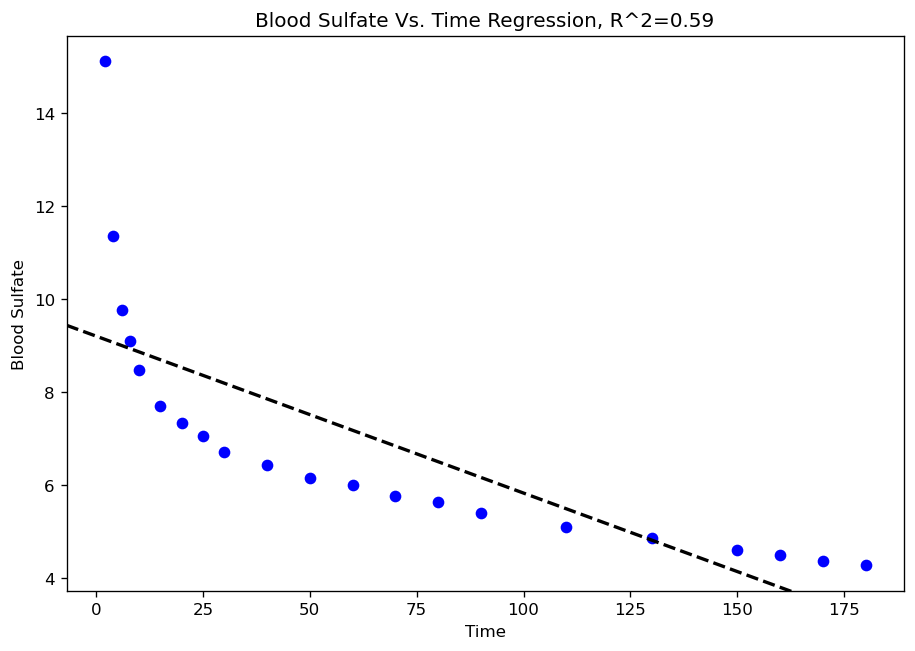

In [42]:
X_1 = df_1['Hours'].values.reshape(-1,1)
Y_1 = df_1['Sulfate'].values.reshape(-1)

fig, ax = plt.subplots(figsize=(9,6.), dpi=120)

beta_1 = linear_regression(X_1,Y_1,lam=0)
ax = draw_regression(X_1,Y_1,beta_1,ax)

residuals_1 = linear_residuals(X_1, beta_1, Y_1)
fitted_1 = linear_predict(X_1, beta_1)

r2_1 = r2_score(Y_1, fitted_1) #computes the R^2 score

ax.set_xlabel('Time')
ax.set_ylabel('Blood Sulfate')
_ = ax.set_title('Blood Sulfate Vs. Time Regression, R^2=%.2f' %r2_1)

Lets compare our result with an off-the-shelf package. The package`seaborn` does the whole linear regression process in a single line. Let's try that, and see how it matches with our plot.

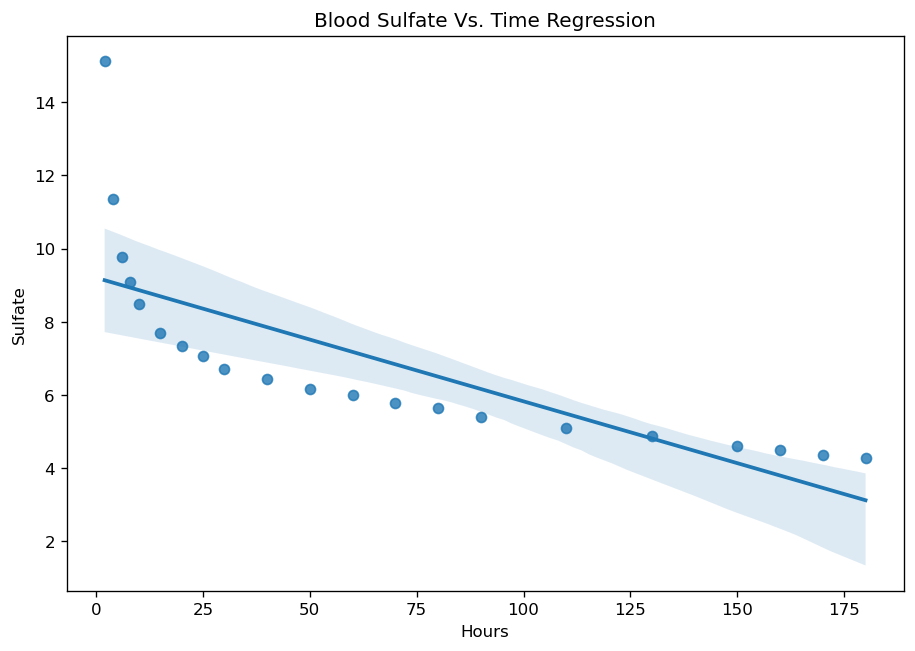

In [43]:
fig, ax = plt.subplots(figsize=(9,6.), dpi=120)
sns.regplot(x='Hours', y='Sulfate', data=df_1, ax=ax)
_ = ax.set_title('Blood Sulfate Vs. Time Regression')

Now we draw the residuals against the fitted values.

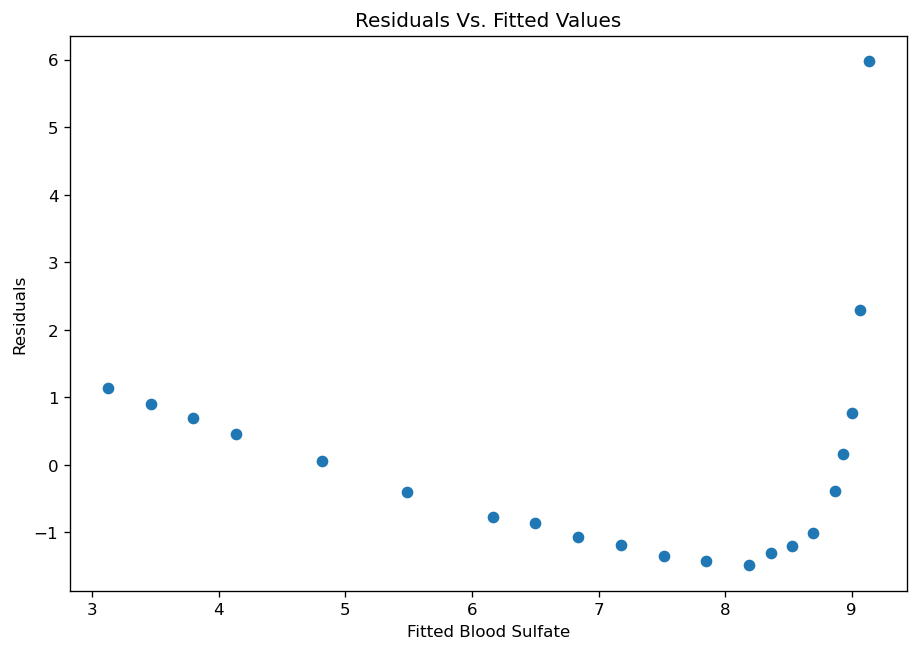

In [44]:
fig, ax = plt.subplots(figsize=(9,6.), dpi=120)
ax.scatter(fitted_1, residuals_1)

ax.set_xlabel('Fitted Blood Sulfate')
ax.set_ylabel('Residuals')
_ = ax.set_title('Residuals Vs. Fitted Values')

### 1.1.2 Regression in the Log-Log Coordinates

Next, we find the linear regression for the log of the blood sulfate level against the log of time. We first use the `linear_regression` and `linear_residuals` functions that you implemented above.

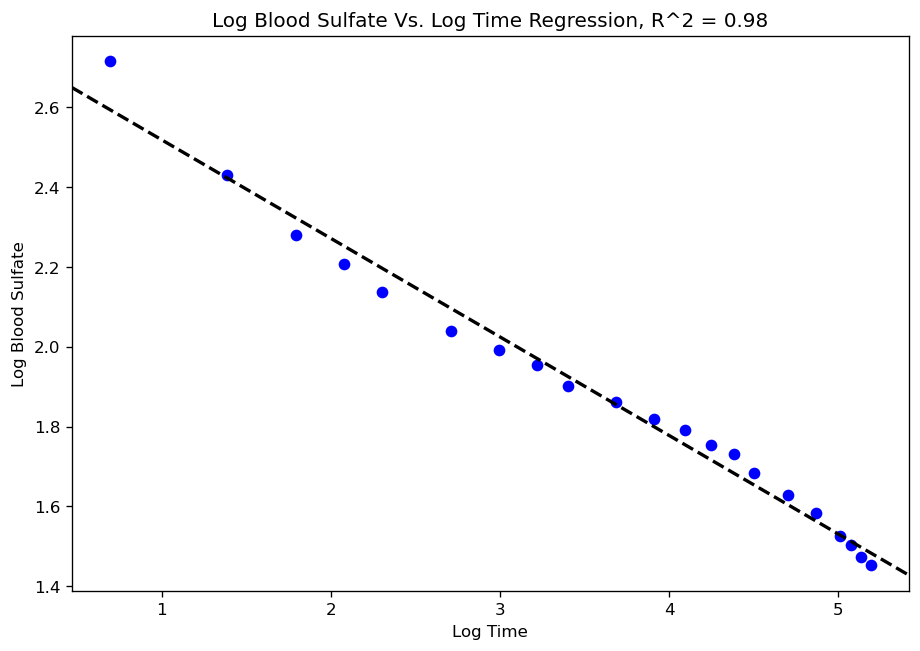

In [45]:
log_X_1 = np.log(df_1['Hours'].values.reshape(-1,1))
log_Y_1 = np.log(df_1['Sulfate'].values.reshape(-1))

fig, ax = plt.subplots(figsize=(9,6.), dpi=120)

beta_1_log = linear_regression(log_X_1,log_Y_1,lam=0)
residuals_1_log = linear_residuals(log_X_1, beta_1_log, log_Y_1)
fitted_1_log = linear_predict(log_X_1, beta_1_log)

r2_1_log = r2_score(log_Y_1, fitted_1_log) #computes the R^2 score

ax = draw_regression(log_X_1,log_Y_1,beta_1_log,ax)

ax.set_xlabel('Log Time')
ax.set_ylabel('Log Blood Sulfate')
_ = ax.set_title('Log Blood Sulfate Vs. Log Time Regression, R^2 = %.2f' %r2_1_log)

We also compare our plot with the `seaborn` package.

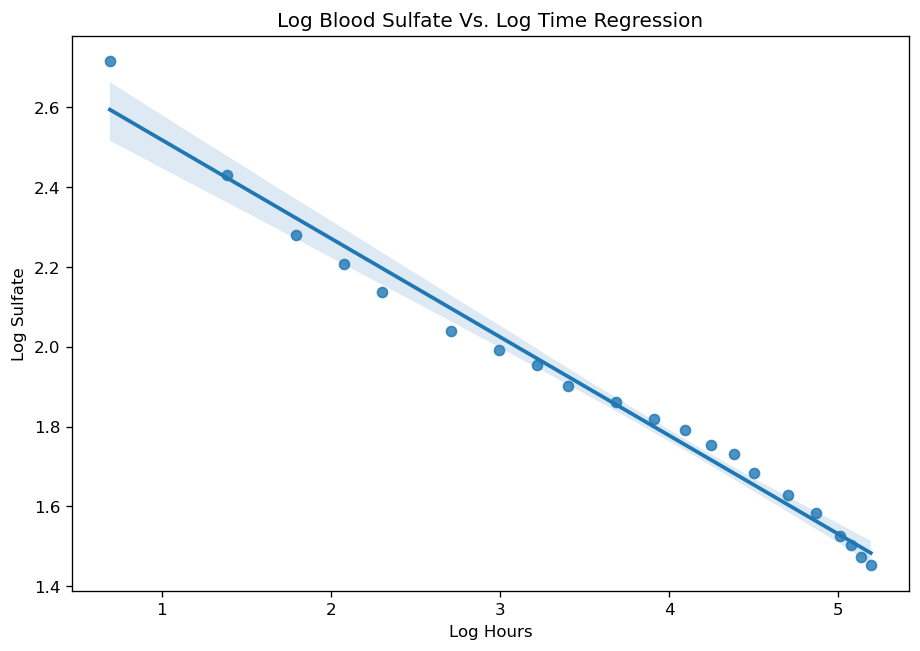

In [46]:
fig, ax = plt.subplots(figsize=(9,6.), dpi=120)
log_df_1 = df_1.copy(deep=True)
log_df_1['Log Hours'] = np.log(df_1['Hours'])
log_df_1['Log Sulfate'] = np.log(df_1['Sulfate'])
sns.regplot(x='Log Hours', y='Log Sulfate', data=log_df_1, ax=ax)
_ = ax.set_title('Log Blood Sulfate Vs. Log Time Regression')

We also plot the residuals against fitted log blood sulfate.

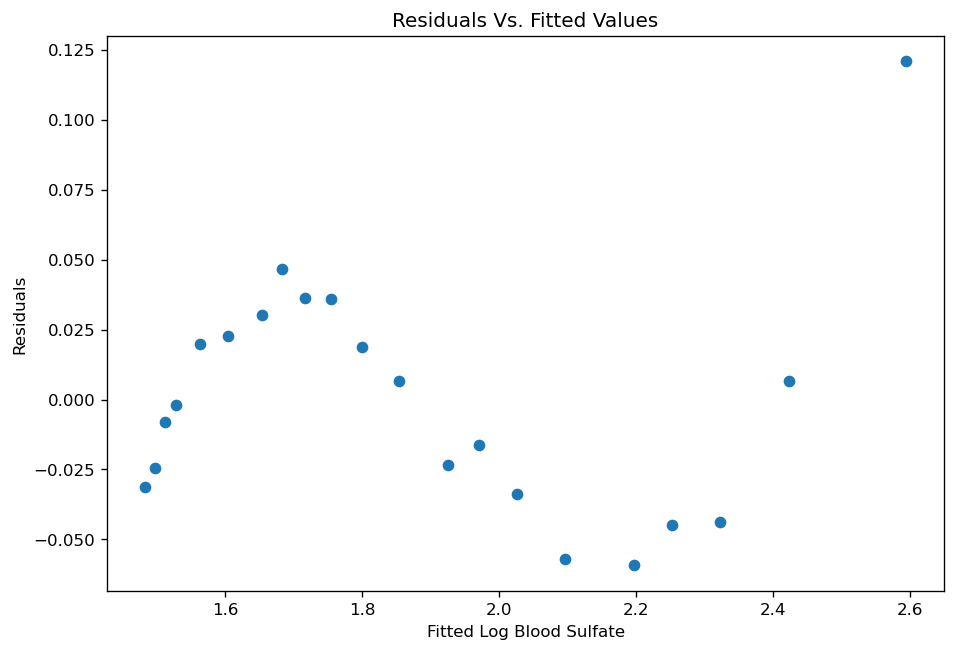

In [47]:
fig, ax = plt.subplots(figsize=(9,6.), dpi=120)
ax.scatter(fitted_1_log, residuals_1_log)

ax.set_xlabel('Fitted Log Blood Sulfate')
ax.set_ylabel('Residuals')
_ = ax.set_title('Residuals Vs. Fitted Values')

# 2. Problem 2

## 2.0 Data

### 2.0.1 Description

At http://www.statsci.org/data/oz/physical.html, you will find a dataset of measurements by M. Larner, made in 1996. These measurements include body mass, and various diameters. Build a linear regression of predicting the body mass from these diameters.

### 2.0.2 Information Summary

* **Input/Output**: This data has 11 columns, with the first column being the body mass and label.

* **Missing Data**: There is no missing data.

* **Final Goal**: We want to fit a linear regression model.

### 2.0.3 Loading The Data

In [48]:
df_2 = pd.read_csv('physical.txt', sep='\t')
df_2

,Mass,Fore,Bicep,Chest,Neck,Shoulder,Waist,Height,Calf,Thigh,Head
0,77.0,28.5,33.5,100.0,38.5,114.0,85.0,178.0,37.5,53.0,58.0
1,85.5,29.5,36.5,107.0,39.0,119.0,90.5,187.0,40.0,52.0,59.0
2,63.0,25.0,31.0,94.0,36.5,102.0,80.5,175.0,33.0,49.0,57.0
3,80.5,28.5,34.0,104.0,39.0,114.0,91.5,183.0,38.0,50.0,60.0
4,79.5,28.5,36.5,107.0,39.0,114.0,92.0,174.0,40.0,53.0,59.0
5,94.0,30.5,38.0,112.0,39.0,121.0,101.0,180.0,39.5,57.5,59.0
6,66.0,26.5,29.0,93.0,35.0,105.0,76.0,177.5,38.5,50.0,58.5
7,69.0,27.0,31.0,95.0,37.0,108.0,84.0,182.5,36.0,49.0,60.0
8,65.0,26.5,29.0,93.0,35.0,112.0,74.0,178.5,34.0,47.0,55.5
9,58.0,26.5,31.0,96.0,35.0,103.0,76.0,168.5,35.0,46.0,58.0


## 2.1 Regression

### 2.1.1 Original Coordinates

We first try to find the linear regression to predict the body mass based on the input diameters in the original coordinates. Note that unlike Problem 1, we have 11 input variables here, and we cannot plot body mass against the input variables and see how the fitted plot behaves. For this, we plot the residuals against the fitted mass. Similar to Problem 1, we do not use regularization and hence $\lambda=0$.

<font color='red'> Attention: </font> Although you are not adding any code in this part, you should see the results, compare them, and think about what is going on. Moreover, you might need to come back and modify the code to answer some questions in the follow-up quiz.

mean square error: 2.61


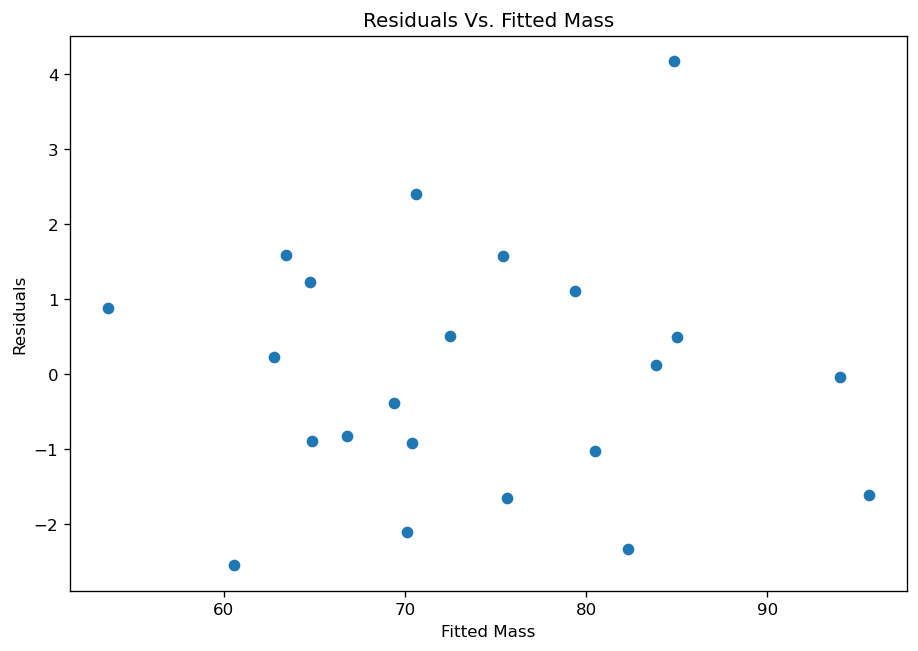

In [49]:
X_2 = df_2.loc[:, df_2.columns != 'Mass'].values
Y_2 = df_2['Mass'].values

fig, ax = plt.subplots(figsize=(9,6.), dpi=120)

beta_2 = linear_regression(X_2,Y_2,lam=0)
residuals_2 = linear_residuals(X_2, beta_2, Y_2)
fitted_2 = linear_predict(X_2, beta_2)

ax.scatter(fitted_2, residuals_2)

ax.set_xlabel('Fitted Mass')
ax.set_ylabel('Residuals')
_ = ax.set_title('Residuals Vs. Fitted Mass')

print('mean square error: %.2f' %np.mean(residuals_2**2))

### 2.1.2 Cubic Root Labels

Now, we find the linear regression between the input variables and the cubic root of the body mass. Then, we plot cubic root residuals against fitted cubic root mass.

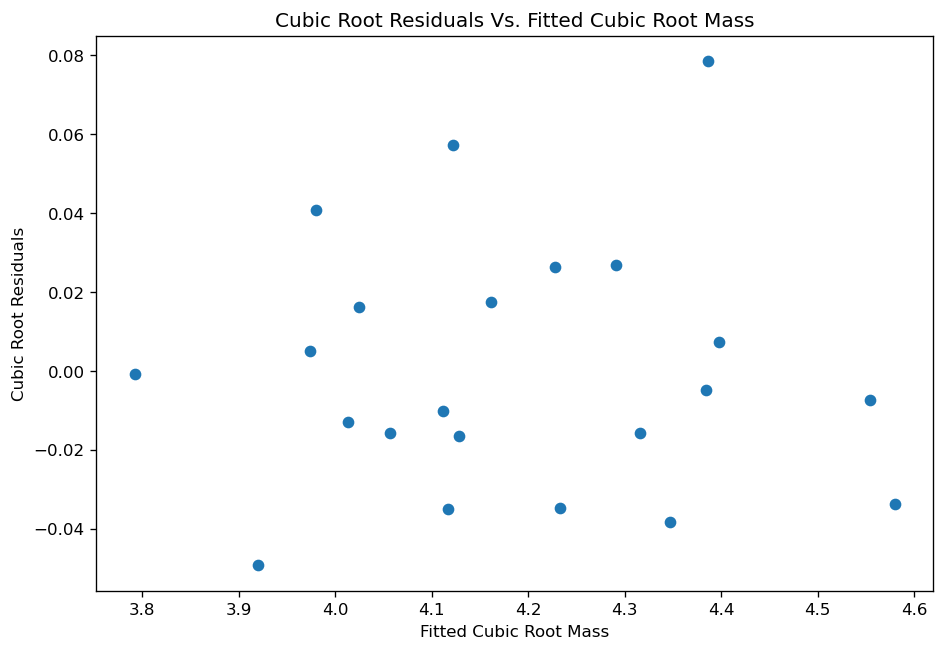

In [50]:
X_2 = df_2.loc[:, df_2.columns != 'Mass'].values
Y_2_cr = (df_2['Mass'].values**(1./3.))

fig, ax = plt.subplots(figsize=(9,6.), dpi=120)

beta_2_cr = linear_regression(X_2,Y_2_cr,lam=0)
residuals_2_cr = linear_residuals(X_2, beta_2_cr, Y_2_cr)
fitted_2_cr = linear_predict(X_2, beta_2_cr)

ax.scatter(fitted_2_cr, residuals_2_cr)

ax.set_xlabel('Fitted Cubic Root Mass')
ax.set_ylabel('Cubic Root Residuals')
_ = ax.set_title('Cubic Root Residuals Vs. Fitted Cubic Root Mass')

### 2.1.3 Cubic Root Labels in the Original Scale

To compare the fitted values in the original scale, we raise the fitted cubic root mass to the power of 3 and compare them with the original mass values. Then, we plot the residuals against fitted cubic root mass to the power of 3.

mean square error: 2.88


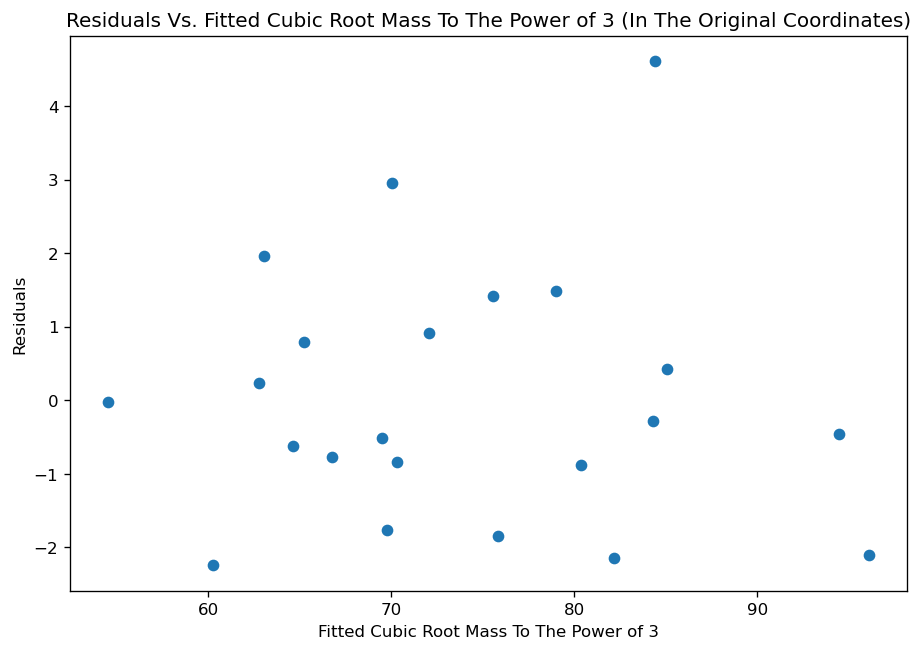

In [51]:
X_2 = df_2.loc[:, df_2.columns != 'Mass'].values
Y_2 = df_2['Mass'].values
Y_2_cr = (Y_2**(1./3.))

fig, ax = plt.subplots(figsize=(9,6.), dpi=120)

beta_2_cr = linear_regression(X_2, Y_2_cr, lam=0)
fitted_2_orig = (linear_predict(X_2, beta_2_cr))**3.
residuals_2_orig = Y_2 - fitted_2_orig


ax.scatter(fitted_2_orig, residuals_2_orig)

ax.set_xlabel('Fitted Cubic Root Mass To The Power of 3')
ax.set_ylabel('Residuals')
_ = ax.set_title('Residuals Vs. Fitted Cubic Root Mass To The Power of 3 (In The Original Coordinates)')

print('mean square error: %.2f' %np.mean(residuals_2_orig**2))

# 3. Problem 3

## 3.0 Data

### 3.0.1 Description

At https://archive.ics.uci.edu/ml/datasets/Abalone, you will find a dataset of measurements by W. J. Nash, T. L. Sellers, S. R. Talbot, A. J. Cawthorn and W. B. Ford, made in 1992. These are a variety of measurements of blacklip abalone (Haliotis rubra; delicious by repute) of various ages and genders.

### 3.0.2 Information Summary

* **Input/Output**: This data has 9 columns, with the last column being the rings count which serves as the age of the abalone and the label.

* **Missing Data**: There is no missing data.

* **Final Goal**: We want to fit a linear regression model predicting the age.

### 3.0.3 Loading The Data

In [52]:
df_3 = pd.read_csv('abalone.data', sep=',', header=None)
df_3.columns = ['Sex', 'Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight', 
              'Viscera weight', 'Shell weight', 'Rings']
df_3

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,7
...,...,...,...,...,...,...,...,...,...
4172,F,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11
4173,M,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10
4174,M,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9
4175,F,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,10


## 3.1 Predicting the age from the measurements, ignoring gender

Our goal is to predict the number of rings against the input variables. However, since the input gender variable is discrete (it is one of the three values `M`, `F`, or `I`), we first ignore the gender input.

<font color='red'> Attention: </font> Although you are not adding any code in this part, you should see the results, compare them, and think about what is going on. Moreover, you might need to come back and modify the code to answer some questions in the follow-up quiz.

mean square error = 4.91


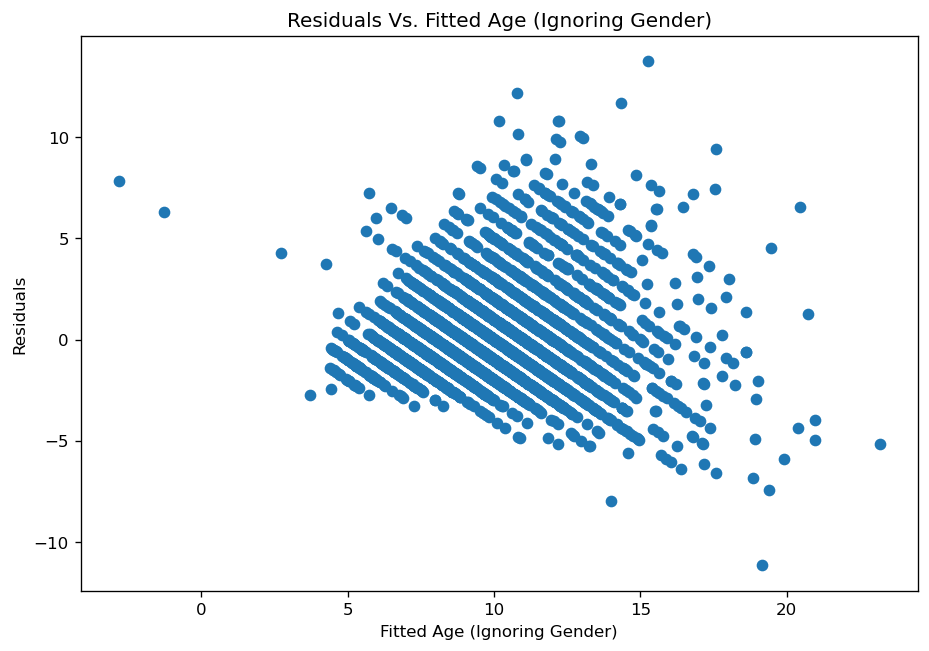

In [53]:
X_3 = df_3.loc[:, (df_3.columns != 'Rings') & (df_3.columns != 'Sex')].values
Y_3 = df_3['Rings'].values

fig, ax = plt.subplots(figsize=(9,6.), dpi=120)

beta_3 = linear_regression(X_3,Y_3,lam=0)
residuals_3 = linear_residuals(X_3, beta_3, Y_3)
fitted_3 = linear_predict(X_3, beta_3)

ax.scatter(fitted_3, residuals_3)

ax.set_xlabel('Fitted Age (Ignoring Gender)')
ax.set_ylabel('Residuals')
_ = ax.set_title('Residuals Vs. Fitted Age (Ignoring Gender)')

print('mean square error = %.2f' %np.mean(residuals_3**2))

## 3.2 Predicting the age from the measurements, including gender

Now, we convert gender into a numeric value by replacing `F` with 1, `M` with 0, and `I` with -1. Then, we again run the linear regression.

mean square error = 4.85


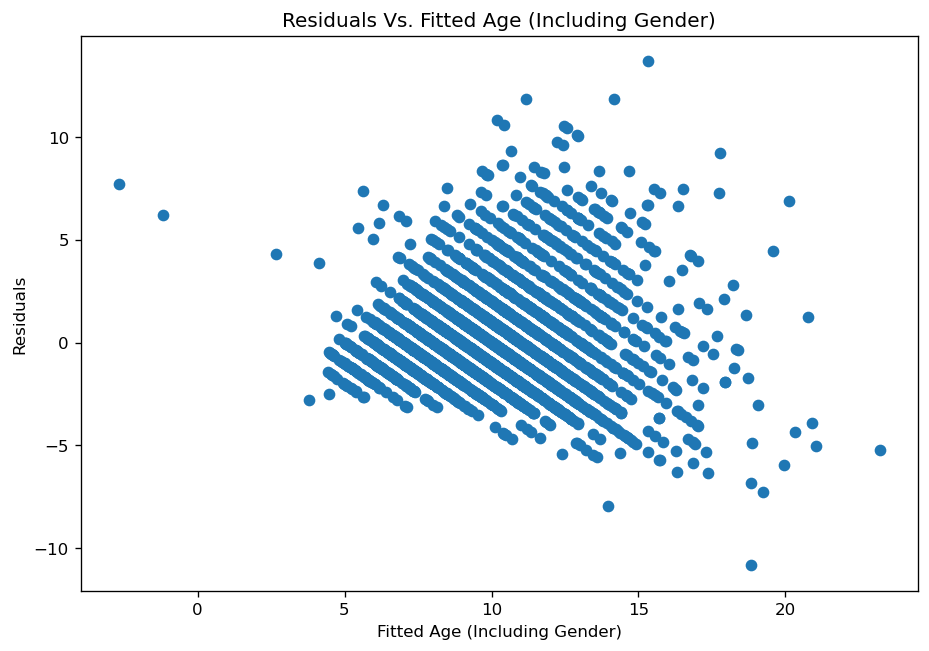

In [54]:
X_3_gender = df_3.loc[:, (df_3.columns != 'Rings') & (df_3.columns != 'Sex')].values
X_3_gender = np.concatenate([X_3, np.array([{'F':1, 'M':0, 'I':-1}.get(x) for x in df_3.Sex]).reshape(-1,1)], axis=1)
Y_3 = df_3['Rings'].values

fig, ax = plt.subplots(figsize=(9,6.), dpi=120)

beta_3_gender = linear_regression(X_3_gender,Y_3,lam=0)
residuals_3_gender = linear_residuals(X_3_gender, beta_3_gender, Y_3)
fitted_3_gender = linear_predict(X_3_gender, beta_3_gender)

ax.scatter(fitted_3_gender, residuals_3_gender)

ax.set_xlabel('Fitted Age (Including Gender)')
ax.set_ylabel('Residuals')
_ = ax.set_title('Residuals Vs. Fitted Age (Including Gender)')

print('mean square error = %.2f' %np.mean(residuals_3_gender**2))

## 3.3 Predicting the log of age from the measurements, ignoring gender

We now find the linear regression of the log of the output against the input variables, ignoring gender.

mean square error (in the original coordinates) = 5.31


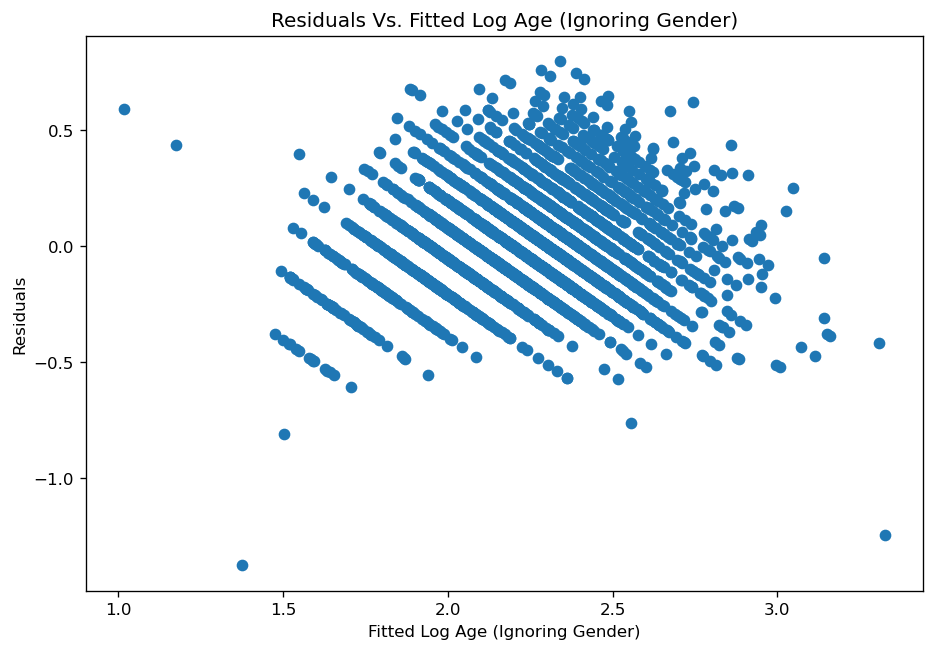

In [55]:
X_3 = df_3.loc[:, (df_3.columns != 'Rings') & (df_3.columns != 'Sex')].values
Y_3 = df_3['Rings'].values
Y_3_log = np.log(df_3['Rings'].values)

fig, ax = plt.subplots(figsize=(9,6.), dpi=120)

beta_3_log = linear_regression(X_3,Y_3_log,lam=0)
residuals_3_log = linear_residuals(X_3, beta_3_log, Y_3_log)
fitted_3_log = linear_predict(X_3, beta_3_log)

ax.scatter(fitted_3_log, residuals_3_log)

ax.set_xlabel('Fitted Log Age (Ignoring Gender)')
ax.set_ylabel('Residuals')
_ = ax.set_title('Residuals Vs. Fitted Log Age (Ignoring Gender)')

fitted_3_log_orig = np.exp(fitted_3_log) #predicted values back to the original coordinates
residuals_3_log_orig = Y_3 - fitted_3_log_orig #residuals in the original coordinates
print('mean square error (in the original coordinates) = %.2f' %np.mean(residuals_3_log_orig**2))

## 3.4 Predicting the log age from the measurements, including gender

We use the same numeric values for the gender as in Section 3.2, and find the linear regression to predict the log of the output against the input variables.

mean square error (in the original coordinates) = 5.24


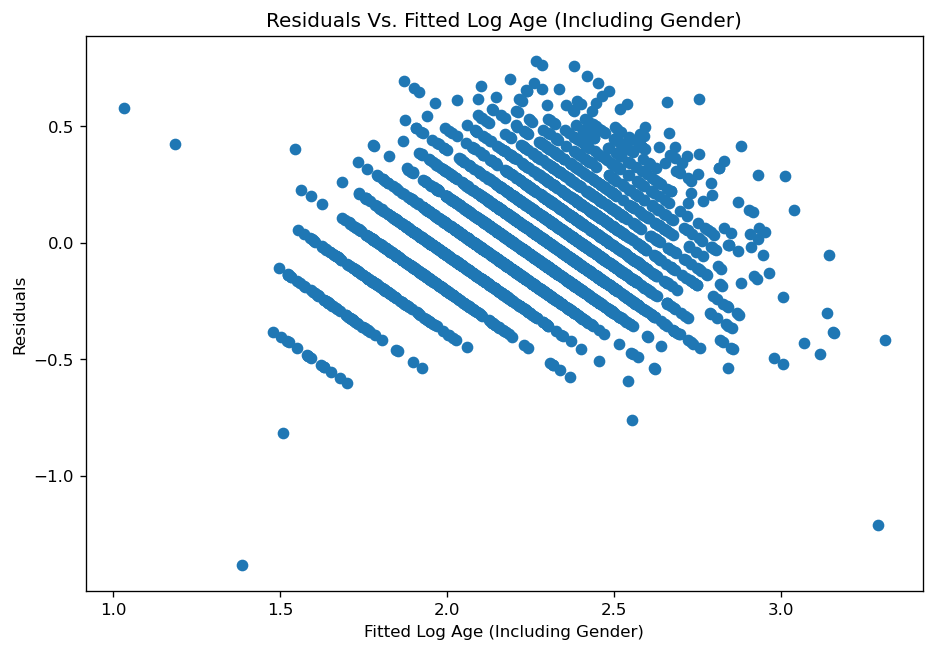

In [56]:
X_3_gender = df_3.loc[:, (df_3.columns != 'Rings') & (df_3.columns != 'Sex')].values
X_3_gender = np.concatenate([X_3_gender, np.array([{'F':1, 'M':0, 'I':-1}.get(x) for x in df_3.Sex]).reshape(-1,1)], axis=1)
Y_3 = df_3['Rings'].values
Y_3_log = np.log(df_3['Rings'].values)

fig, ax = plt.subplots(figsize=(9,6.), dpi=120)

beta_3_gender_log = linear_regression(X_3_gender,Y_3_log,lam=0)
residuals_3_gender_log = linear_residuals(X_3_gender, beta_3_gender_log, Y_3_log)
fitted_3_gender_log = linear_predict(X_3_gender, beta_3_gender_log)

ax.scatter(fitted_3_gender_log, residuals_3_gender_log)

ax.set_xlabel('Fitted Log Age (Including Gender)')
ax.set_ylabel('Residuals')
_ = ax.set_title('Residuals Vs. Fitted Log Age (Including Gender)')

fitted_3_gender_log_orig = np.exp(fitted_3_gender_log) # predicted values back to the original coordinates
residuals_3_gender_log = Y_3 - fitted_3_gender_log_orig
print('mean square error (in the original coordinates) = %.2f' %np.mean(residuals_3_gender_log**2))


## 3.5 Applying Cross Validation For Regularization

We now bring the regularization into play. We use cross validation to find the value of $\lambda$ to predict the log of the output variable against all the input variables. We convert the gender input to a numeric value using the conversion in Section 3.2. We then plot the cross-validation mean square error against the log of $\lambda$.

In the following code, the variable `Y_transform` determines whether we try to predict the labels in the original coordinates or in the logarithmic space. If the value of `Y_transform` is `linear`, we apply linear transformation in the original coordinates, and if its value is `log`, we use logarithmic transformation. In case we work in the logarithmic space, in order to find the mean square error, after finding the predicted values, we transform them back into the original coordinates using `np.exp` and then compare them to the correct values.

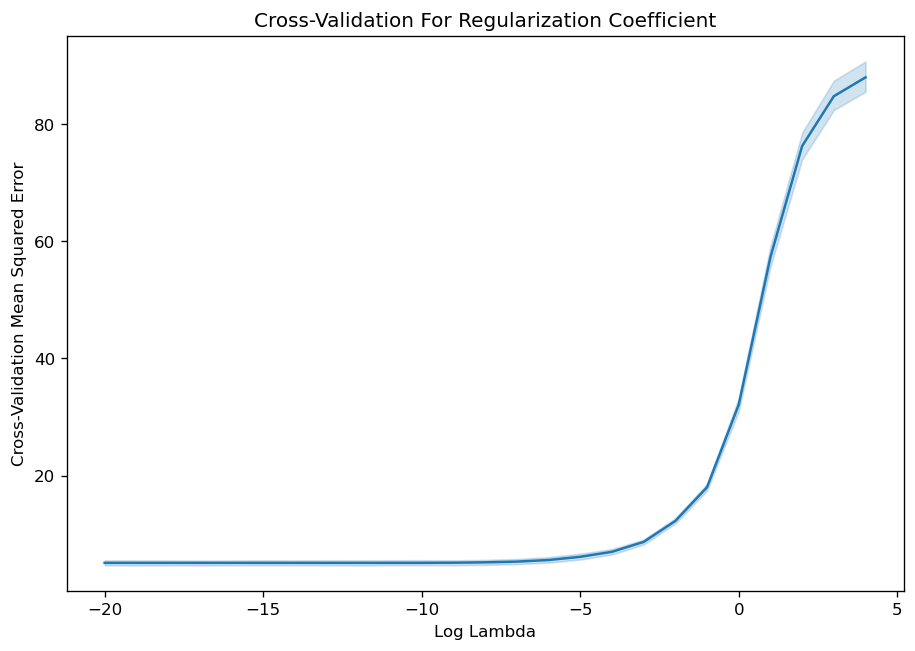

In [57]:
log_lambda_list = np.arange(-20, 5)
X_3_gender = df_3.loc[:, (df_3.columns != 'Rings') & (df_3.columns != 'Sex')].values
X_3_gender = np.concatenate([X_3_gender, np.array([{'F':1, 'M':0, 'I':-1}.get(x) for x in df_3.Sex]).reshape(-1,1)], axis=1)
Y_3 = df_3['Rings'].values
Y_3_log = np.log(df_3['Rings'].values)

Y_transform = 'log' # 'linear': output variable in the original coordinate is considered, 'log': log of output is considered

if Y_transform == 'linear':
    X_train_val, X_test, Y_train_val, Y_test = train_test_split(X_3_gender, Y_3, test_size=0.2, random_state=12345)
if Y_transform == 'log':
    X_train_val, X_test, Y_train_val, Y_test = train_test_split(X_3_gender, Y_3_log, test_size=0.2, random_state=12345)

kf = KFold(n_splits=10, shuffle=True, random_state=12345)

cross_val_mses = []
for train_idx, val_idx in kf.split(X_train_val):
    X_train, X_val, Y_train, Y_val = X_train_val[train_idx], X_train_val[val_idx], Y_train_val[train_idx], Y_train_val[val_idx]
    
    for log_lambda in log_lambda_list:
        beta_3_cv = linear_regression(X_train, Y_train, lam=np.exp(log_lambda))
        if Y_transform == 'linear':
            val_residuals = linear_residuals(X_val, beta_3_cv, Y_val)
            
        if Y_transform == 'log':
            val_predict_log = linear_predict(X_val, beta_3_cv) # predicted in log space
            val_predict_log_orig = np.exp(val_predict_log) # get back to original coordinates

            val_residuals = np.exp(Y_val) - val_predict_log_orig
            
        val_mse = np.mean(val_residuals**2)
        
        cross_val_mses.append([log_lambda, val_mse])

cross_val_mses = np.array(cross_val_mses)
fig, ax = plt.subplots(figsize=(9,6.), dpi=120)
x_name, y_name = 'Log Lambda', 'Cross-Validation Mean Squared Error'
cv_df = pd.DataFrame(cross_val_mses, columns =[x_name, y_name])
sns.lineplot(x=x_name, y=y_name,data=cv_df, ax=ax)
_ = ax.set_title('Cross-Validation For Regularization Coefficient')

Lets see what was the best value of $\lambda$ and the corresponding mean square error.

In [58]:
avg_cv_err_df = cv_df.groupby(x_name).mean()
best_log_lam = avg_cv_err_df[y_name].idxmin()
best_cv_mse = avg_cv_err_df.loc[best_log_lam][y_name]

print(f'Best Log Lambda value was {best_log_lam} with a cross-validation MSE of %.3f' %best_cv_mse)

beta_full = linear_regression(X_train_val,Y_train_val,lam=np.exp(best_log_lam))

if Y_transform == 'linear':
    test_residuals = linear_residuals(X_test, beta_full, Y_test)
    test_mse = np.mean(test_residuals**2)
if Y_transform == 'log':
    test_predict = linear_predict(X_test, beta_full)
    test_predict_orig = np.exp(test_predict)
    test_residuals = np.exp(Y_test) - test_predict_orig
    test_mse = np.mean(test_residuals**2)
print(f'The resulting test mean squared error would be %.3f' % test_mse)

Best Log Lambda value was -13.0 with a cross-validation MSE of 5.144
The resulting test mean squared error would be 10.706
